<a href="https://colab.research.google.com/github/supriyag123/PHD_Pub/blob/main/PAPER_GDRNet_ELECTRICITY_Step4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

aic1_count :  [-416.77285383024116, -407.6921404709317, -421.15743624245835, -419.0130002733995, -414.03749580947516, -417.2089550380644, -418.34556726966946, -415.3472382186352, -415.70851890995164, -417.0831583005129, -419.0861103258035, -419.455272809309, -418.4353385292438, -417.12040438764893, -415.2388414424708, -414.7385434395052, -417.0347664985225, -422.15070727678994, -411.48996296175574, -417.7966757350202, -415.6850956966167, -416.27224876928113, -419.4011707183207, -413.5027756894577, -411.28825200195223, -419.76853164791083, -420.877813484613, -411.1679016302617, -425.82928890477376, -414.32346705836557, -420.2250146240541, -419.85404552137743, -415.82022561381086, -415.8501613733193, -412.60920018816245, -425.8943964909614, -413.4377689101349, -412.9233023415115, -418.6168232398695, -416.55769309559594, -416.5255469744393, -416.01276306863093, -410.2170728505594, -415.1430412581095, -415.02120917618123, -415.53436394360926, -422.08939248947144, -422.81823401717713, -421.

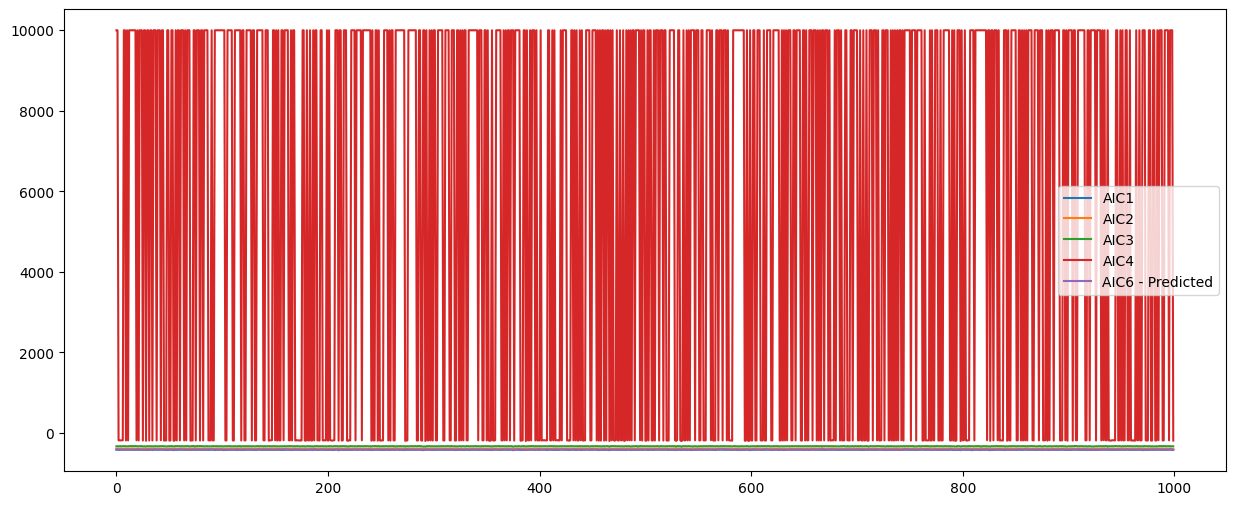

In [106]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import math
import plotly.graph_objects as go
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, RepeatVector, TimeDistributed, Input
from keras.models import Model
from keras import backend as K
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import EarlyStopping
import keras.backend as K
from keras.callbacks import Callback
import plotly
import plotly.express as px # for data visualization
import seaborn as sns
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
import numpy as np
import scipy.stats as stats
from numpy import array
from numpy import hstack
from numpy import mean
from numpy import std
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LassoCV, MultiTaskLassoCV
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import TimeSeriesSplit
from math import sqrt
from sklearn.linear_model import LinearRegression
from keras.models import Model
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic
from statsmodels.tsa.stattools import acf

#-----------------------------------------------------GET DATA - X, Predicted Wndow from MLP, and Derived Labels, for the entire dataset that was gennerated through VAE-----------------------------------

#-----------for whole dataset-----------------------------------------------------------------------
y_pred = np.loadtxt(r'/content/drive/MyDrive/PHD/2024/MLPOutput/predicted_COSW_V3.csv')
y_true = np.loadtxt(r'/content/drive/MyDrive/PHD/2024/MLPOutput/Calculated_label_COSW_V3.csv')
x_orig = np.loadtxt(r'/content/drive/MyDrive/PHD/2024/MLPOutput/whole_data_V3.csv')


#-----------for test dataset-----------------------------------------------------------------------
y_pred = np.loadtxt(r'/content/drive/MyDrive/PHD/2024/MLPOutput/predicted_window_V3.csv')
y_true = np.loadtxt(r'/content/drive/MyDrive/PHD/2024/MLPOutput/derived_window_label_V3.csv')
x_orig = np.loadtxt(r'/content/drive/MyDrive/PHD/2024/MLPOutput/test_data_V3.csv')

n_features = 6
window_size = int(x_orig.shape[1]/n_features)
x = x_orig.reshape((x_orig.shape[0],window_size,n_features))

sample_size = 5000
#-----------------------------------------------CASES - pot window values and pick a few fixed window sizes -------------------------------------------



plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
plt.title("Distribution before Transformation", fontsize=15)
sns.histplot(y_true, kde=True, color="red")
plt.subplot(1,2,2)


fx_window1 = 5
fx_window2 = 10
fx_window3 = 15
fx_window4 = 20
fx_window5 = 25


pred_step =5

############################METHOD 1---------------- GO BY AIC ---------------------------------------------------------------------------------

aic1_count = list()
aic2_count = list()
aic3_count = list()
aic4_count = list()
aic5_count = list()
aic6_count = list()





for i in range(sample_size) :

  x1 = x[i]
  x_train=x1[:-pred_step]
  x_test=x1[-pred_step:]
  regressor= VAR(x_train)
  results1 = regressor.fit(fx_window1)
  results2 = regressor.fit(fx_window2)
  results3 = regressor.fit(fx_window3)
  results4 = regressor.fit(fx_window4)
  #results5 = regressor.fit(fx_window5)
  results6 = regressor.fit(int(y_pred[i]))

#Calculate AIC for ach case--------------
  try:
    aic1 = results1.aic
  except:
    aic1 = 9999
  aic1_count.append(aic1)

  try:
    aic2 = results2.aic
  except:
    aic2 = 9999
  aic2_count.append(aic2)

  try:
    aic3 = results3.aic
  except:
    aic3 = 9999
  aic3_count.append(aic3)

  try:
    aic4 = results4.aic
  except:
    aic4 = 9999
  aic4_count.append(aic4)

  #try:
  #  aic5 = results5.aic
  #except:
  #  aic5 = 9999
  #aic5_count.append(aic5)


  try:
    aic6 = results6.aic
  except:
    aic6 = 9999
  aic6_count.append(aic6)


print("aic1_count : ", aic1_count)
print("aic2_count : ", aic2_count)
print("aic3_count : ", aic3_count)
print("aic4_count : ", aic4_count)
#print("aic5_count : ", aic5_count)
print("aic6_count : ", aic6_count)

df = pd.DataFrame({'AIC1' : aic1_count, 'AIC2' : aic2_count, 'AIC3' : aic3_count,  'AIC4':aic4_count, 'AIC6 - Predicted' : aic6_count})
df[0:1000].plot(figsize=(15,6))
plt.legend()
plt.show()


df.to_csv('/content/drive/MyDrive/PHD/2024/PREDICTION_COMPARISON/Electricity_AIC_comparison.csv', index = False)

################---------------------------METHOD 2- -GO BY RMSE----------------------------------------------------####################
def forecast_accuracy(forecast, actual, variance):
  se = (forecast - actual)**2  # SE
  mse = np.mean(se)  # MSE
  nmse = mse/variance  # NMSE
  return nmse

def global_nmse(df, df_train, df_test, i, window):

  model_fitted = model.fit(window)
  lag_order = model_fitted.k_ar
  forecast_input = df.values[-lag_order:]
  fc = model_fitted.forecast(y=forecast_input, steps=pred_step)
  df_forecast = pd.DataFrame(fc, index=df.index[-pred_step:], columns=df.columns)

  nmse_v1 = forecast_accuracy(df_forecast['V1'].values, df_test['V1'], np.var(df_train['V1']))
  nmse_v2 = forecast_accuracy(df_forecast['V2'].values, df_test['V2'], np.var(df_train['V2']))
  nmse_v3 = forecast_accuracy(df_forecast['V3'].values, df_test['V3'], np.var(df_train['V3']))
  nmse_v4 = forecast_accuracy(df_forecast['V4'].values, df_test['V4'], np.var(df_train['V4']))
  nmse_v5 = forecast_accuracy(df_forecast['V5'].values, df_test['V5'], np.var(df_train['V5']))
  nmse_v6 = forecast_accuracy(df_forecast['V6'].values, df_test['V6'], np.var(df_train['V6']))
  nmse_total = np.mean([nmse_v1, nmse_v2, nmse_v3, nmse_v4, nmse_v5, nmse_v6])
  return nmse_total

#------------------------------------V1----------------------------------------

nmse_w1_list = list()
nmse_w2_list = list()
nmse_w3_list = list()
nmse_w4_list = list()
nmse_w5_list = list()
nmse_w6_list = list()
nmse_wx_list = list()





#--------w1-------------------
for i in range(sample_size) :
  x1 = x[i]
  df = pd.DataFrame(x1, columns=['V1','V2','V3','V4','V5','V6'])
  df_train, df_test = df[0:-pred_step], df[-pred_step:]
  model= VAR(df_train)
  nmse = global_nmse(df, df_train, df_test, i,fx_window1)
  nmse_w1_list.append(nmse)

overall_nmse_w1 = sum(nmse_w1_list)/len(nmse_w1_list)


#--------w2-------------------
for i in range(sample_size) :
  x1 = x[i]
  df = pd.DataFrame(x1, columns=['V1','V2','V3','V4','V5','V6'])
  df_train, df_test = df[0:-pred_step], df[-pred_step:]
  model= VAR(df_train)
  nmse = global_nmse(df, df_train, df_test, i,fx_window2)
  nmse_w2_list.append(nmse)

overall_nmse_w2 = sum(nmse_w2_list)/len(nmse_w2_list)


#--------w3-------------------
for i in range(sample_size) :
  x1 = x[i]
  df = pd.DataFrame(x1, columns=['V1','V2','V3','V4','V5','V6'])
  df_train, df_test = df[0:-pred_step], df[-pred_step:]
  model= VAR(df_train)
  nmse = global_nmse(df, df_train, df_test, i,fx_window3)
  nmse_w3_list.append(nmse)

overall_nmse_w3 = sum(nmse_w3_list)/len(nmse_w3_list)

#--------w3-------------------
for i in range(sample_size) :
  x1 = x[i]
  df = pd.DataFrame(x1, columns=['V1','V2','V3','V4','V5','V6'])
  df_train, df_test = df[0:-pred_step], df[-pred_step:]
  model= VAR(df_train)
  nmse = global_nmse(df, df_train, df_test, i,fx_window4)
  nmse_w4_list.append(nmse)

overall_nmse_w4 = sum(nmse_w4_list)/len(nmse_w4_list)

#--------wx-------------------

for i in range(sample_size) :
  x1 = x[i]
  df = pd.DataFrame(x1, columns=['V1','V2','V3','V4','V5','V6'])
  df_train, df_test = df[0:-pred_step], df[-pred_step:]
  model= VAR(df_train)
  nmse = global_nmse(df, df_train, df_test, i,int(y_pred[i]))
  nmse_wx_list.append(nmse)

overall_nmse_wx = sum(nmse_wx_list)/len(nmse_wx_list)

print(overall_nmse_w1)
print(overall_nmse_w2)
print(overall_nmse_w3)
print(overall_nmse_w4)
print(overall_nmse_wx)




In [ ]:
from google.colab import drive
drive.mount('/content/drive')